In [1]:
import pandas as pd
import numpy as np

# Logistic regression
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from utils import evaluate

# Modelado

In [2]:
X_train = pd.read_parquet('../data/X_train.parquet')
y_train = pd.read_parquet('../data/y_train.parquet')

X_test  = pd.read_parquet('../data/X_test.parquet')
y_test  = pd.read_parquet('../data/y_test.parquet')

y_train = y_train['DEATH_EVENT']
y_test  = y_test['DEATH_EVENT']

In [3]:
features_selected = ['serum_sodium', 
                     'platelets', 
                     'creatinine_phosphokinase', 
                     'age',
                     'ejection_fraction',
                     'serum_creatinine'
                    ]

X_train = X_train.loc[: , features_selected]
X_test = X_test.loc[: , features_selected]

In [5]:
lr = LogisticRegression(C = 1e6, max_iter = 200)
lr.fit(X_train, y_train)

LogisticRegression(C=1000000.0, max_iter=200)

# Evaluación

In [6]:
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]

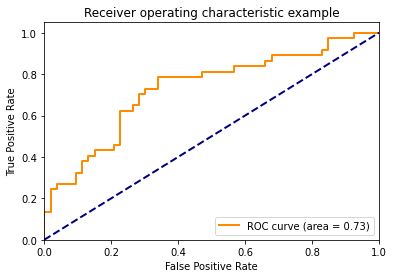

In [7]:
metrics = evaluate(y_test, y_pred, y_proba)

In [8]:
metrics

{'recall': 0.2702702702702703,
 'precision': 0.7692307692307693,
 'f1': 0.4,
 'accuracy': 0.6666666666666666,
 'auc': 0.7292197858235594}

In [9]:
from joblib import dump
dump(lr, '../models/logistic_regression.pkl')

['../models/logistic_regression.pkl']

### Validación cruzada

In [40]:
from sklearn.model_selection import KFold, cross_val_score

In [41]:
# prepare configuration for cross validation test harness
seed    = 7
model   = LogisticRegression(max_iter = 200, C = 1e6)
scoring = 'precision'

kfold = KFold(n_splits = 10, shuffle = True, random_state = seed)
cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)

### Tuneo regularización

In [10]:
from sklearn.model_selection import GridSearchCV

In [21]:
model   = LogisticRegression(max_iter = 200)
scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'accuracy':'accuracy'}

#grid = {'C': [1000, 100, 10, 0.1, 0.01, 0.0001]}
grid = {'C': [10, 0.1, 0.08, 0.02, 0.001, 0.0001, 0.015, 0.0001]}

grid_search = GridSearchCV(estimator = model, 
                           param_grid = grid, 
                           n_jobs = -1,
                           cv = 5,
                           scoring = scoring,
                           refit = 'precision'
                           )

In [22]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200), n_jobs=-1,
             param_grid={'C': [10, 0.1, 0.08, 0.02, 0.001, 0.0001, 0.015,
                               0.0001]},
             refit='precision',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [23]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: 0.692222 using {'C': 0.02}


In [24]:
lr_r = LogisticRegression(max_iter = 200, C = 0.02)
lr_r.fit(X_train, y_train)

LogisticRegression(C=0.02, max_iter=200)

# Evaluación

In [25]:
y_pred  = lr_r.predict(X_test)
y_proba = lr_r.predict_proba(X_test)[:,1]

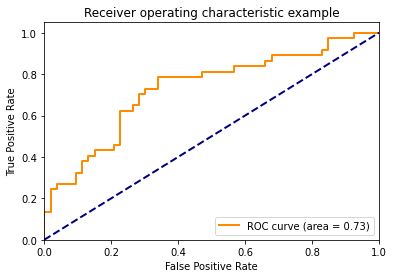

{'recall': 0.2702702702702703,
 'precision': 0.7692307692307693,
 'f1': 0.4,
 'accuracy': 0.6666666666666666,
 'auc': 0.7292197858235594}

In [26]:
metrics = evaluate(y_test, y_pred, y_proba)
metrics

In [28]:
dump(lr_r, '../models/logistic_regression_regularized.pkl')

['../models/logistic_regression_regularized.pkl']

## Comparacion de los modelos

LR: 0.741310 (0.240216)
LRR: 0.881429 (0.126463)


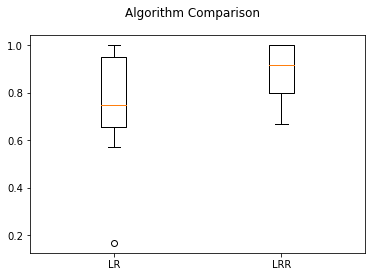

In [76]:
# prepare models
models = []
models.append( ('LR', LogisticRegression(max_iter = 200, C = 1e6)) )
models.append( ('LRR', LogisticRegression(max_iter = 200, C = 0.0001)) )

# evaluate each model in turn
results = []
names = []
scoring = 'precision'

for name, model in models:
    kfold = KFold(n_splits = 10, shuffle = True, random_state = seed)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()